# 06_EDA: Multimodal Alignment (센서 길이 vs 영상 길이)

센서 데이터와 영상 데이터의 길이(프레임/샘플 수) 비교 및 정렬 상태 EDA 노트북입니다.
- 센서 데이터: 각 샘플의 센서 파일 행 수
- 영상 데이터: 각 샘플의 영상 프레임 수 또는 길이
- 목적: 두 모달리티의 길이 불일치, 정렬 상태, 이상치 탐색

## 1. 필요 라이브러리 임포트

분석에 필요한 라이브러리를 임포트합니다.

In [20]:
# 필요 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. 데이터 로드 및 기본 확인

train_clean.csv와 video_metadata.csv를 불러오고, 주요 컬럼과 샘플을 확인합니다.

In [21]:
# 데이터 로드 및 기본 확인
df_clean = pd.read_csv('train_clean.csv')
df_video = pd.read_csv('video_metadata.csv')

display(df_clean.head())
display(df_video.head())
print('train_clean.csv 컬럼:', df_clean.columns.tolist())
print('video_metadata.csv 컬럼:', df_video.columns.tolist())

,sample_id,class,image_dir,video_dir,sensor_dir
0,02181_H_A_N_C1,N/N,../data/train/raw/image/N/N/02181_H_A_N_C1,../data/train/raw/video/N/N/02181_H_A_N_C1,../data/train/raw/sensor/N/N/02181_H_A_N_C1
1,02117_H_A_N_C6,N/N,../data/train/raw/image/N/N/02117_H_A_N_C6,../data/train/raw/video/N/N/02117_H_A_N_C6,../data/train/raw/sensor/N/N/02117_H_A_N_C6
2,02497_H_A_N_C5,N/N,../data/train/raw/image/N/N/02497_H_A_N_C5,../data/train/raw/video/N/N/02497_H_A_N_C5,../data/train/raw/sensor/N/N/02497_H_A_N_C5
3,02604_H_A_N_C2,N/N,../data/train/raw/image/N/N/02604_H_A_N_C2,../data/train/raw/video/N/N/02604_H_A_N_C2,../data/train/raw/sensor/N/N/02604_H_A_N_C2
4,00322_H_A_N_C3,N/N,../data/train/raw/image/N/N/00322_H_A_N_C3,../data/train/raw/video/N/N/00322_H_A_N_C3,../data/train/raw/sensor/N/N/00322_H_A_N_C3


,sample_id,class,video_path,fps,frame_count,width,height,duration
0,02181_H_A_N_C1,N,../data/train/raw/video/N/N/02181_H_A_N_C1/021...,10.0,100,1280,720,10.0
1,02117_H_A_N_C6,N,../data/train/raw/video/N/N/02117_H_A_N_C6/021...,10.0,100,1280,720,10.0
2,02497_H_A_N_C5,N,../data/train/raw/video/N/N/02497_H_A_N_C5/024...,10.0,100,1280,720,10.0
3,02604_H_A_N_C2,N,../data/train/raw/video/N/N/02604_H_A_N_C2/026...,10.0,100,1280,720,10.0
4,00322_H_A_N_C3,N,../data/train/raw/video/N/N/00322_H_A_N_C3/003...,10.0,100,1280,720,10.0


train_clean.csv 컬럼: ['sample_id', 'class', 'image_dir', 'video_dir', 'sensor_dir']
video_metadata.csv 컬럼: ['sample_id', 'class', 'video_path', 'fps', 'frame_count', 'width', 'height', 'duration']


## 3. 센서 데이터 길이 추출

각 샘플의 센서 파일 경로(sensor_dir)를 이용해 센서 데이터의 길이(행 수)를 추출합니다.

In [22]:
def get_sensor_path(sensor_dir, sample_id):
    return os.path.join(sensor_dir, f"{sample_id}.csv")

# 센서 길이 추출 함수 수정
def get_sensor_length(sensor_dir, sample_id):
    sensor_path = get_sensor_path(sensor_dir, sample_id)
    if not os.path.exists(sensor_path):
        return np.nan
    try:
        df = pd.read_csv(sensor_path)
        return len(df)
    except Exception as e:
        print(f"[경고] 센서 파일 읽기 실패: {sensor_path}")
        return np.nan

df_clean['sensor_length'] = df_clean.apply(lambda row: get_sensor_length(row['sensor_dir'], row['sample_id']), axis=1)
print('센서 길이 샘플')
display(df_clean[['sample_id', 'sensor_dir', 'sensor_length']].head())

센서 길이 샘플


,sample_id,sensor_dir,sensor_length
0,02181_H_A_N_C1,../data/train/raw/sensor/N/N/02181_H_A_N_C1,100
1,02117_H_A_N_C6,../data/train/raw/sensor/N/N/02117_H_A_N_C6,100
2,02497_H_A_N_C5,../data/train/raw/sensor/N/N/02497_H_A_N_C5,100
3,02604_H_A_N_C2,../data/train/raw/sensor/N/N/02604_H_A_N_C2,100
4,00322_H_A_N_C3,../data/train/raw/sensor/N/N/00322_H_A_N_C3,100


## 4. 영상 데이터 길이 추출

video_metadata.csv에서 각 샘플의 영상 프레임 수 또는 길이 정보를 추출합니다.

In [23]:
# 영상 데이터 길이 추출 (예시: 'frame_count' 컬럼 사용)
if 'frame_count' in df_video.columns:
    df_video['video_length'] = df_video['frame_count']
else:
    print('video_metadata.csv에 frame_count 컬럼이 없습니다. 실제 컬럼명을 확인하세요.')
print('영상 길이 샘플')
display(df_video[['sample_id', 'video_length']].head())

영상 길이 샘플


,sample_id,video_length
0,02181_H_A_N_C1,100
1,02117_H_A_N_C6,100
2,02497_H_A_N_C5,100
3,02604_H_A_N_C2,100
4,00322_H_A_N_C3,100


## 5. 센서-영상 길이 비교 및 시각화

센서 길이와 영상 길이를 sample_id 기준으로 매칭하여 비교하고, 분포 및 상관관계를 시각화합니다.

매칭된 샘플 수: 4128


,sample_id,sensor_length,video_length
0,02181_H_A_N_C1,100,100
1,02117_H_A_N_C6,100,100
2,02497_H_A_N_C5,100,100
3,02604_H_A_N_C2,100,100
4,00322_H_A_N_C3,100,100


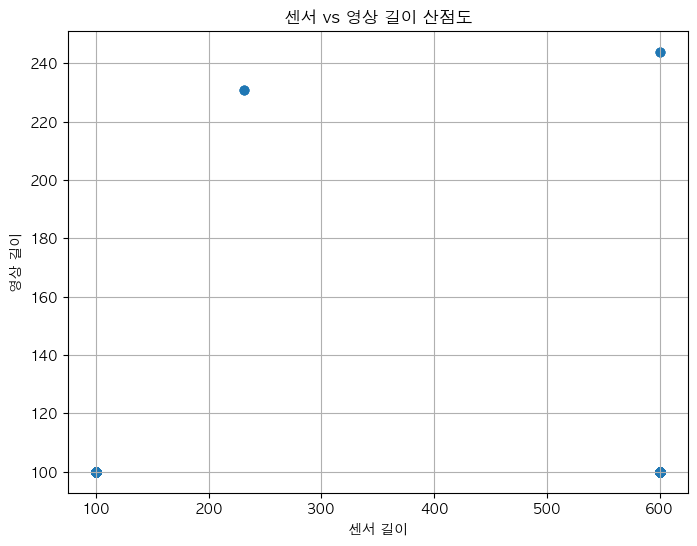

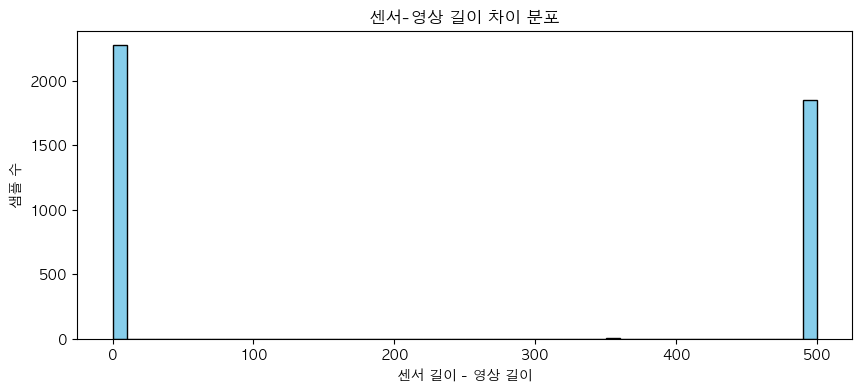

In [24]:
# 센서-영상 길이 비교 및 시각화
df_align = pd.merge(df_clean, df_video[['sample_id', 'video_length']], on='sample_id', how='inner')
print('매칭된 샘플 수:', len(df_align))
display(df_align[['sample_id', 'sensor_length', 'video_length']].head())


plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,6))
plt.scatter(df_align['sensor_length'], df_align['video_length'], alpha=0.5)
plt.xlabel('센서 길이')
plt.ylabel('영상 길이')
plt.title('센서 vs 영상 길이 산점도')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df_align['sensor_length'] - df_align['video_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('센서-영상 길이 차이 분포')
plt.xlabel('센서 길이 - 영상 길이')
plt.ylabel('샘플 수')
plt.show()

## 6. 길이 불일치 샘플 탐색 및 분석

센서와 영상 길이가 크게 차이나는 샘플을 탐색하고, 상세 정보를 분석합니다.

In [25]:
# 길이 불일치 샘플 탐색 및 분석
df_align['length_diff'] = df_align['sensor_length'] - df_align['video_length']
outlier_thresh = 10 
outliers = df_align[df_align['length_diff'].abs() > outlier_thresh]
print(f'길이 불일치(outlier) 샘플 수: {len(outliers)}')
display(outliers[['sample_id', 'sensor_length', 'video_length', 'length_diff']].head())

# 불일치 샘플 상세 정보
for i, row in outliers.head(30).iterrows():
    print(f"샘플 {row['sample_id']}")
    print(f"센서 길이: {row['sensor_length']}, 영상 길이: {row['video_length']}, 차이: {row['length_diff']}")
    print(f"센서 경로: {row['sensor_dir']}")
    print(f"영상 경로: {row['video_dir']}")
    print('-'*40)

길이 불일치(outlier) 샘플 수: 1856


,sample_id,sensor_length,video_length,length_diff
2272,02091_H_A_SY_C7,600,100,500
2273,00022_H_A_SY_C8,600,100,500
2274,02107_H_A_SY_C8,600,100,500
2275,02211_H_A_SY_C7,600,100,500
2276,00112_H_A_SY_C1,600,100,500


샘플 02091_H_A_SY_C7
센서 길이: 600, 영상 길이: 100, 차이: 500
센서 경로: ../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7
영상 경로: ../data/train/raw/video/Y/SY/02091_H_A_SY_C7
----------------------------------------
샘플 00022_H_A_SY_C8
센서 길이: 600, 영상 길이: 100, 차이: 500
센서 경로: ../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8
영상 경로: ../data/train/raw/video/Y/SY/00022_H_A_SY_C8
----------------------------------------
샘플 02107_H_A_SY_C8
센서 길이: 600, 영상 길이: 100, 차이: 500
센서 경로: ../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8
영상 경로: ../data/train/raw/video/Y/SY/02107_H_A_SY_C8
----------------------------------------
샘플 02211_H_A_SY_C7
센서 길이: 600, 영상 길이: 100, 차이: 500
센서 경로: ../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7
영상 경로: ../data/train/raw/video/Y/SY/02211_H_A_SY_C7
----------------------------------------
샘플 00112_H_A_SY_C1
센서 길이: 600, 영상 길이: 100, 차이: 500
센서 경로: ../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1
영상 경로: ../data/train/raw/video/Y/SY/00112_H_A_SY_C1
----------------------------------------
샘플 02922_H_B_SY

## 결론

모든 센서  
센서 길이: 600, 영상 길이: 100.0, 차이: 500.0


In [26]:
import pandas as pd

# 병합
df_merged = pd.merge(df_clean, df_video[['sample_id', 'frame_count']], on='sample_id', how='left')

In [29]:
# 10Hz 기준 센서 데이터 다운샘플링 예시 코드
import pandas as pd
import os

# 센서 데이터 다운샘플링 함수 (10Hz 기준)
def downsample_sensor(sensor_path, target_length):
    if not os.path.exists(sensor_path):
        return None
    df = pd.read_csv(sensor_path)
    if len(df) <= target_length:
        return df  # 이미 target 이하면 그대로 반환
    # 등간격으로 target_length만큼 샘플링
    idx = np.linspace(0, len(df)-1, target_length).astype(int)
    return df.iloc[idx].reset_index(drop=True)

# 센서 다운샘플링 결과 저장 예시
save_dir = 'sensor_downsampled_10Hz'
os.makedirs(save_dir, exist_ok=True)

for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    sensor_path = os.path.join(row['sensor_dir'], f"{row['sample_id']}.csv")
    # 해당 sample_id의 영상 길이(프레임 수) 가져오기
    video_info = df_video[df_video['sample_id'] == row['sample_id']]
    if video_info.empty or pd.isna(video_info.iloc[0]['frame_count']) or video_info.iloc[0]['frame_count'] == 0:
        print(f"[스킵] 영상 길이 NaN 또는 0: {row['sample_id']}")
        continue
    video_length = int(video_info.iloc[0]['frame_count'])
    # 10Hz 기준 다운샘플링 (예: 영상 프레임 수와 동일하게 맞춤)
    sensor_down = downsample_sensor(sensor_path, video_length)
    if sensor_down is not None:
        sensor_down.to_csv(os.path.join(save_dir, f"{row['sample_id']}_10Hz.csv"), index=False)
    else:
        print(f"[스킵] 센서 파일 없음: {row['sample_id']}")

100%|██████████| 4128/4128 [00:41<00:00, 100.20it/s]


In [31]:

# 센서 파일에서 시간 컬럼 추정 (예: 'time', 'timestamp', 'frame', 't', 등)
def get_sensor_hz(sensor_path):
    if not os.path.exists(sensor_path):
        return None
    df = pd.read_csv(sensor_path)
    # 시간 컬럼 자동 탐색
    time_cols = [c for c in df.columns if c.lower() in ['time', 'timestamp', 't', 'frame']]
    if not time_cols:
        print(f"[경고] 시간 컬럼 없음: {sensor_path}")
        return None
    time_col = time_cols[0]
    times = df[time_col].values
    # 시간 단위가 초(s) 또는 ms로 추정
    if len(times) < 2:
        return None
    dt = times[1] - times[0]
    # ms 단위면 변환
    if dt > 1:  # 1초 이상이면 ms 단위로 가정
        dt = dt / 1000.0
    hz = 1.0 / dt if dt > 0 else None
    return hz

# 센서 HZ 분포 확인
hz_list = []
for i, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    sensor_path = os.path.join(row['sensor_dir'], f"{row['sample_id']}.csv")
    hz = get_sensor_hz(sensor_path)
    hz_list.append(hz)
df_clean['sensor_hz'] = hz_list
print('센서 HZ 분포:')
print(df_clean['sensor_hz'].describe())
print(df_clean[['sample_id', 'sensor_hz']].head())

100%|██████████| 4128/4128 [00:16<00:00, 256.19it/s]

센서 HZ 분포:
count    4128.000000
mean       92.826873
std        84.288492
min         1.000000
25%         1.000000
50%       166.666667
75%       166.666667
max       500.000000
Name: sensor_hz, dtype: float64
        sample_id   sensor_hz
0  02181_H_A_N_C1  166.666667
1  02117_H_A_N_C6  166.666667
2  02497_H_A_N_C5  166.666667
3  02604_H_A_N_C2  166.666667
4  00322_H_A_N_C3  166.666667
